In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, round

from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, Imputer, OneHotEncoder

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

from functions import join_data, one_hot_encoder



from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession \
    .builder \
    .appName("Proyecto") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar").getOrCreate()


ps: unrecognized option: p
BusyBox v1.30.1 (2019-10-26 11:23:07 UTC) multi-call binary.

Usage: ps [-o COL1,COL2=HEADER]

Show list of processes

	-o COL1,COL2=HEADER	Select columns for display
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/28 01:28:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [3]:

# Cargar el conjunto de datos. Esta vez desde la base de datos
students_1 = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "students_1_clean")\
    .load()


students_2 = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "students_2_clean")\
    .load()


In [4]:
#unimos los conjuntos de datos

students = join_data(students_1, students_2, "ID", "ID", "inner")
students.show()

+----+-----+----------+--------------------+-------------------+--------------------------+-----------+---------------+----------------+---------------+-----------------+-------------+---------------+-----------+--------------+-----------------+---------------------+------------------------+------------------+------+----------+
|  ID|Hours|Attendance|Parental_Involvement|Access_to_Resources|Extracurricular_Activities|Sleep_Hours|Previous_Scores|Motivation_Level|Internet_Access|Tutorihg_Sessions|Family_Income|Teacher_Quality|School_Type|Peer_Influence|Physical_Activity|Learning_Disabilities|Parental_Education_Level|Distance_from_Home|Gender|Exam_Score|
+----+-----+----------+--------------------+-------------------+--------------------------+-----------+---------------+----------------+---------------+-----------------+-------------+---------------+-----------+--------------+-----------------+---------------------+------------------------+------------------+------+----------+
| 148|   1

In [7]:
#hacemos O_H_E a "Peer_Influence"
students = one_hot_encoder(students, "Peer_Influence")
students.show()

+----+-----+----------+--------------------+-------------------+--------------------------+-----------+---------------+----------------+---------------+-----------------+-------------+---------------+-----------+-----------------+---------------------+------------------------+------------------+------+----------+------------------+
|  ID|Hours|Attendance|Parental_Involvement|Access_to_Resources|Extracurricular_Activities|Sleep_Hours|Previous_Scores|Motivation_Level|Internet_Access|Tutorihg_Sessions|Family_Income|Teacher_Quality|School_Type|Physical_Activity|Learning_Disabilities|Parental_Education_Level|Distance_from_Home|Gender|Exam_Score|Peer_Influence_vec|
+----+-----+----------+--------------------+-------------------+--------------------------+-----------+---------------+----------------+---------------+-----------------+-------------+---------------+-----------+-----------------+---------------------+------------------------+------------------+------+----------+------------------

In [8]:
students.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Hours: integer (nullable = true)
 |-- Attendance: integer (nullable = true)
 |-- Parental_Involvement: integer (nullable = true)
 |-- Access_to_Resources: integer (nullable = true)
 |-- Extracurricular_Activities: integer (nullable = true)
 |-- Sleep_Hours: integer (nullable = true)
 |-- Previous_Scores: integer (nullable = true)
 |-- Motivation_Level: integer (nullable = true)
 |-- Internet_Access: integer (nullable = true)
 |-- Tutorihg_Sessions: integer (nullable = true)
 |-- Family_Income: integer (nullable = true)
 |-- Teacher_Quality: integer (nullable = true)
 |-- School_Type: integer (nullable = true)
 |-- Physical_Activity: integer (nullable = true)
 |-- Learning_Disabilities: integer (nullable = true)
 |-- Parental_Education_Level: integer (nullable = true)
 |-- Distance_from_Home: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Exam_Score: integer (nullable = true)
 |-- Peer_Influence_vec: vector (nullable = 

In [9]:
assembler = VectorAssembler(inputCols = ["Hours", "Attendance", "Parental_Involvement", "Access_to_Resources", \
                                         "Extracurricular_Activities", "Sleep_Hours", "Previous_Scores", \
                                         "Motivation_Level", "Internet_Access", "Tutorihg_Sessions", "Family_Income", \
                                         "Teacher_Quality", "Physical_Activity", "Learning_Disabilities", \
                                         "Parental_Education_Level", "Distance_from_Home", "Gender", "School_Type", \
                                         "Peer_Influence_vec"], outputCol="features")

vector_df = assembler.transform(students)

vector_df = vector_df.select("features", "Exam_Score")
vector_df.show()


25/07/28 01:29:44 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+----------+
|            features|Exam_Score|
+--------------------+----------+
|[12.0,96.0,1.0,3....|        68|
|[16.0,61.0,2.0,1....|        63|
|[18.0,80.0,2.0,1....|        65|
|[23.0,88.0,1.0,2....|        67|
|[14.0,81.0,3.0,2....|        64|
|[21.0,95.0,2.0,1....|        70|
|[17.0,95.0,1.0,3....|        69|
|[20.0,90.0,1.0,2....|        66|
|[15.0,65.0,3.0,2....|        63|
|[14.0,74.0,2.0,3....|        66|
|[14.0,86.0,1.0,1....|        65|
|[19.0,82.0,1.0,1....|        64|
|[26.0,81.0,2.0,3....|        73|
|[25.0,82.0,2.0,2....|        67|
|[20.0,90.0,3.0,3....|        70|
|[29.0,86.0,1.0,1....|        68|
|[21.0,76.0,1.0,3....|        66|
|[18.0,98.0,2.0,3....|        69|
|[14.0,92.0,3.0,1....|        66|
|[29.0,64.0,1.0,2....|        63|
+--------------------+----------+
only showing top 20 rows



25/07/28 01:29:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


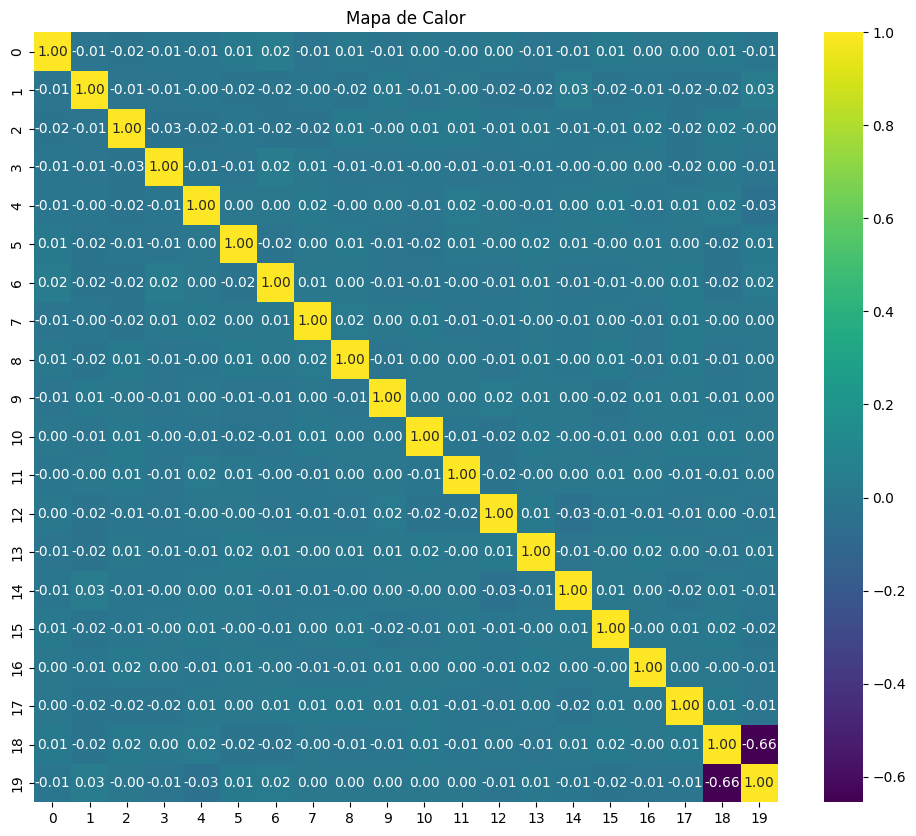

In [10]:
# Con la representación de vectores podemos calcular correlaciones
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

pearson_matrix = Correlation.corr(vector_df, 'features').collect()[0][0]

plt.figure(figsize = (12,10))
sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')

plt.title("Mapa de Calor")
plt.show()

In [11]:
#escalamos los datos
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(vector_df)
scaled_df = scaler_model.transform(vector_df)

In [12]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

#separar en training y testing

splits = scaled_df.randomSplit([0.8, 0.2], 1234)
train_df = splits[0]
test_df = splits[1]


In [13]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
#haciendo random forest

rf = RandomForestRegressor(labelCol="Exam_Score", featuresCol="scaled_features", seed = 1234)

#definiendo hiperparámetros
paramGrid = ParamGridBuilder()\
            .addGrid(rf.numTrees, [10, 50])\
            .addGrid(rf.maxDepth, [5, 10])\
            .build()

#evaluador
mae_evaluator_rf = RegressionEvaluator(labelCol = "Exam_Score",\
                                              predictionCol = "prediction",\
                                              metricName = "mae")

#validación cruzada
cv_rf = CrossValidator(estimator = rf,\
                    estimatorParamMaps = paramGrid,\
                    evaluator = mae_evaluator_rf,\
                    numFolds = 3,\
                    seed = 1234)

#entrenar el modelo
cv_rf_model = cv_rf.fit(train_df)


#evaluar en test
predictions_test_rf = cv_rf_model.transform(test_df)
mae_test_rf = mae_evaluator_rf.evaluate(predictions_test_rf)
print("MAE test:", mae_test_rf)


#evaluar en training
predictions_train_rf = cv_rf_model.transform(train_df)
mae_train_rf = mae_evaluator_rf.evaluate(predictions_train_rf)
print("MAE training:", mae_train_rf)


25/07/28 01:30:25 WARN DAGScheduler: Broadcasting large task binary with size 1294.2 KiB
25/07/28 01:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1165.5 KiB
25/07/28 01:30:51 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/28 01:30:57 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/07/28 01:31:05 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
25/07/28 01:31:13 WARN DAGScheduler: Broadcasting large task binary with size 1002.7 KiB
25/07/28 01:31:35 WARN DAGScheduler: Broadcasting large task binary with size 1316.3 KiB
25/07/28 01:31:58 WARN DAGScheduler: Broadcasting large task binary with size 1159.5 KiB
25/07/28 01:32:01 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/07/28 01:32:07 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/07/28 01:32:15 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
25/07/28 01:32:23 WARN DAGScheduler: Br

MAE test: 1.1836119423871634
MAE training: 0.7609667677993688


In [13]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="scaled_features", labelCol= "Exam_Score", maxIter=10)


#definiendo hiperparámetros
paramGrid = ParamGridBuilder()\
            .addGrid(gbt.maxIter, [10, 50])\
            .addGrid(gbt.maxDepth, [5, 10])\
            .build()

#evaluador
mae_evaluator_gbt = RegressionEvaluator(labelCol = "Exam_Score",\
                                              predictionCol = "prediction",\
                                              metricName = "mae")

#validación cruzada
cv_gbt = CrossValidator(estimator = gbt,\
                    estimatorParamMaps = paramGrid,\
                    evaluator = mae_evaluator_gbt,\
                    numFolds = 3,\
                    seed = 1234)

#entrenar el modelo
cv_gbt_model = cv_gbt.fit(train_df)

#evaluar en test
predictions_test_gbt = cv_gbt_model.transform(test_df)
mae_test_gbt = mae_evaluator_gbt.evaluate(predictions_test_gbt)
print("MAE test:", mae_test_gbt)

#evaluar en training
predictions_train_gbt = cv_gbt_model.transform(train_df)
mae_train_gbt = mae_evaluator_gbt.evaluate(predictions_train_gbt)
print("MAE training:", mae_train_gbt)

25/07/27 23:24:46 WARN DAGScheduler: Broadcasting large task binary with size 1001.0 KiB
25/07/27 23:24:47 WARN DAGScheduler: Broadcasting large task binary with size 1048.7 KiB
25/07/27 23:24:49 WARN DAGScheduler: Broadcasting large task binary with size 1042.8 KiB
25/07/27 23:24:50 WARN DAGScheduler: Broadcasting large task binary with size 1043.3 KiB
25/07/27 23:24:50 WARN DAGScheduler: Broadcasting large task binary with size 1043.9 KiB
25/07/27 23:24:51 WARN DAGScheduler: Broadcasting large task binary with size 1045.0 KiB
25/07/27 23:24:51 WARN DAGScheduler: Broadcasting large task binary with size 1047.3 KiB
25/07/27 23:24:52 WARN DAGScheduler: Broadcasting large task binary with size 1051.2 KiB
25/07/27 23:24:53 WARN DAGScheduler: Broadcasting large task binary with size 1058.5 KiB
25/07/27 23:24:53 WARN DAGScheduler: Broadcasting large task binary with size 1071.5 KiB
25/07/27 23:24:54 WARN DAGScheduler: Broadcasting large task binary with size 1092.6 KiB
25/07/27 23:24:55 WAR

MAE test: 1.0917507358344405
MAE training: 0.7258147165708617


# Análisis de Resultados

Primeramente, el modelo generado a partir de Random Forest da un valor de MAE en training y testing de 0.76 y 1.18 respectivamente. Existe un ligero subajuste pero es mínimo y no relevante dado que la variable a predecir toma valores entre 0 y 100, concluyendose así que este modelo generaliza apropiadamente los datos.

En lo que al GBT respecta, sus resultados son de un MAE en training y testing de 0.72 y 1.09 respectivamente, evidenciando un mínimo subajuste no preocupante. Se concluye también que este modelo generaliza bien los datos.

Comparando ambos modelos, GBT genera un mejor MAE en training y testing que RF. Esto puede ser debido a que GBT funciona aprendiendo de errores anteriores cometidos en cada árbol, a diferencia de RF que entrena árboles de forma independiente, por lo que es posible que haya un error sistemático que RF no pudo solucionar. A pesar de esto, GBT no genera un modelo remarcablemente mejor que RF.

De ambos modelos se elige el generado por Random Forest, dado que los resultados del MAE no son muy diferentes, sin embargo, el tiempo de ejecución de GBT es notablemente mayor, haciéndolo menos eficaz.

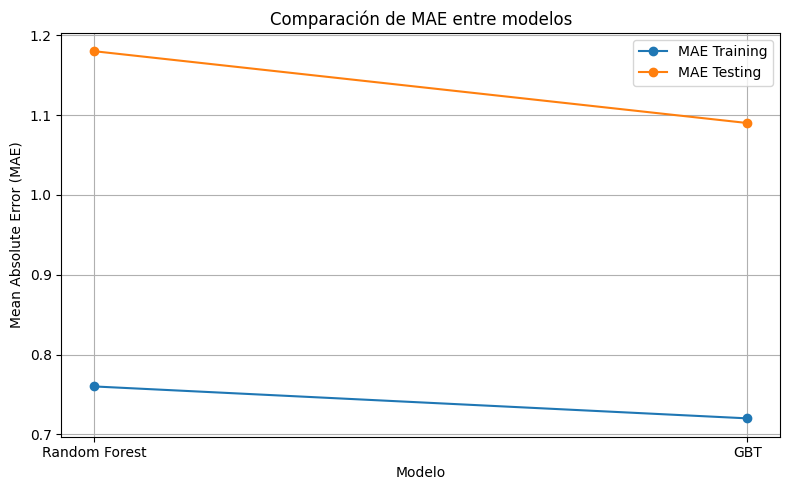

In [17]:

# Nombres de los modelos
modelos = ['Random Forest', 'GBT']

# MAE en training y testing para cada modelo
mae_train = [0.76, 0.72]
mae_test = [1.18, 1.09]

# Crear figura
plt.figure(figsize=(8, 5))

# Graficar líneas
plt.plot(modelos, mae_train, marker='o', label='MAE Training')
plt.plot(modelos, mae_test, marker='o', label='MAE Testing')

# Etiquetas y título
plt.title('Comparación de MAE entre modelos')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Modelo')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()